This notebook contains code from the article [Automated Keyword Extraction from Articles using NLP](https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34). It uses the [NIPS Papers](https://www.kaggle.com/datasets/benhamner/nips-papers) dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilianabadillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lilianabadillo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("data/papers.csv")

In [3]:
df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7241 non-null   int64 
 1   year        7241 non-null   int64 
 2   title       7241 non-null   object
 3   event_type  2422 non-null   object
 4   pdf_name    7241 non-null   object
 5   abstract    7241 non-null   object
 6   paper_text  7241 non-null   object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


## Preprocessing

In [5]:
df[df.abstract != 'Abstract Missing'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3924 entries, 941 to 6947
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3924 non-null   int64 
 1   year        3924 non-null   int64 
 2   title       3924 non-null   object
 3   event_type  2422 non-null   object
 4   pdf_name    3924 non-null   object
 5   abstract    3924 non-null   object
 6   paper_text  3924 non-null   object
dtypes: int64(2), object(5)
memory usage: 245.2+ KB


The article mentions that it only considers those articles that do have and abstract. Also, the title and abstract are concatenated.

In [6]:
articles = df[df.abstract != 'Abstract Missing'][['year', 'title', 'abstract']].copy()

In [7]:
articles.head()

,year,title,abstract
941,2000,Algorithms for Non-negative Matrix Factorization,Non-negative matrix factorization (NMF) has pr...
1067,2001,Characterizing Neural Gain Control using Spike...,Spike-triggered averaging techniques are effec...
2384,2007,Competition Adds Complexity,It is known that determinining whether a DEC-P...
2385,2007,Efficient Principled Learning of Thin Junction...,We present the first truly polynomial algorith...
2388,2007,Regularized Boost for Semi-Supervised Learning,Semi-supervised inductive learning concerns ho...


In [8]:
articles['text'] = articles.title.str.cat(articles.abstract, sep=' ')

In [9]:
articles.drop(['title', 'abstract'], axis=1, inplace=True)

In [10]:
articles.reset_index(drop=True, inplace=True)

In [11]:
# Convert all text to lowercase
articles['text'] = articles['text'].str.lower()

In [12]:
articles.head()

,year,text
0,2000,algorithms for non-negative matrix factorizati...
1,2001,characterizing neural gain control using spike...
2,2007,competition adds complexity it is known that d...
3,2007,efficient principled learning of thin junction...
4,2007,regularized boost for semi-supervised learning...


## Exploratory data analysis

In [13]:
articles['word_count'] = articles['text'].apply(lambda x: len(str(x).split(' ')))

In [14]:
articles.head()

,year,text,word_count
0,2000,algorithms for non-negative matrix factorizati...,112
1,2001,characterizing neural gain control using spike...,88
2,2007,competition adds complexity it is known that d...,70
3,2007,efficient principled learning of thin junction...,150
4,2007,regularized boost for semi-supervised learning...,124


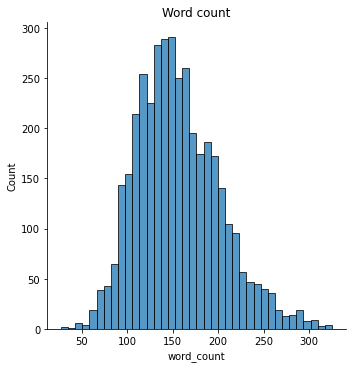

In [15]:
sns.displot(x="word_count", data=articles)
plt.title("Word count");

In [16]:
# Check the most common words
word_freq = pd.DataFrame(' '.join(articles['text']).split()).value_counts()

In [17]:
word_freq[:30]

the          32587
of           21691
a            17237
and          14229
to           13534
in           11963
we           11406
for           8777
that          7856
is            7698
on            5922
with          5236
this          4949
as            3903
learning      3831
our           3783
an            3577
are           3552
by            3477
can           2969
from          2839
which         2786
be            2676
model         2619
algorithm     2329
data          2295
show          2214
it            1726
problem       1652
using         1639
dtype: int64

<AxesSubplot:xlabel='0'>

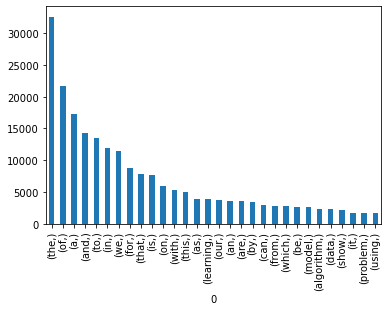

In [18]:
word_freq[:30].plot(kind='bar')

<AxesSubplot:xlabel='0'>

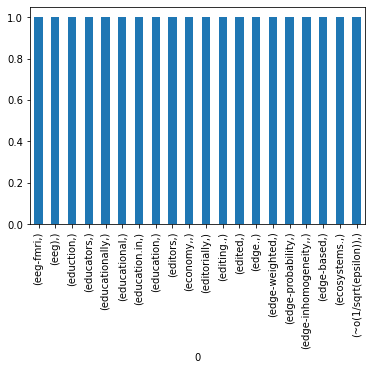

In [19]:
word_freq[-20:].plot(kind='bar')

## Text preprocessing

In [20]:
# Create a list of stopwords
stop_words = set(stopwords.words("english"))

# Create a list of custom stopwords
custom_stop_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]

stop_words = stop_words.union(custom_stop_words)